# Build and Train

In [1]:
import tensorflow as tf
from maxent.data.mnist import load_mnist
from maxent.boltzmann.base import State, train
from maxent.boltzmann.bernoulli import (
    BernoulliBoltzmannMachine, HintonInitializer, LogInternalInformation,
    initialize_fantasy_state, get_reconstruction_error, NoConnection,
    DenseConnections)
from maxent.utils import get_random_connections

IMAGE_SIZE = (16, 16)
SEED = 42

tf.random.set_seed(SEED)

In [2]:
(X, y), _ = load_mnist(image_size=IMAGE_SIZE, binarize=True,
                       minval=0, maxval=1)

ambient_size = IMAGE_SIZE[0] * IMAGE_SIZE[1]
latent_size = 64
batch_size = 128
epochs = 30
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(10000).repeat(epochs).batch(batch_size)
bm = BernoulliBoltzmannMachine(
    ambient_size=ambient_size,
    latent_size=latent_size,
    initializer=HintonInitializer(X),
    max_step=100,
    tolerance=1e-1,
    ambient_ambient_connections=NoConnection(),
    ambient_latent_connections=(
        get_random_connections(ambient_size, latent_size, 0.1)),
    # latent_latent_connections=(
    #     get_random_connections(latent_size, latent_size, 0.2)),
    latent_latent_connections=DenseConnections(),
    # sync_ratio=0.25,
    seed=SEED,
)
fantasy_state = initialize_fantasy_state(bm, batch_size, SEED)
optimizer = tf.optimizers.Adam()
callbacks = [
    LogInternalInformation(bm, log_step=100),
]
fantasy_state = train(bm, optimizer, dataset, fantasy_state, callbacks=callbacks)

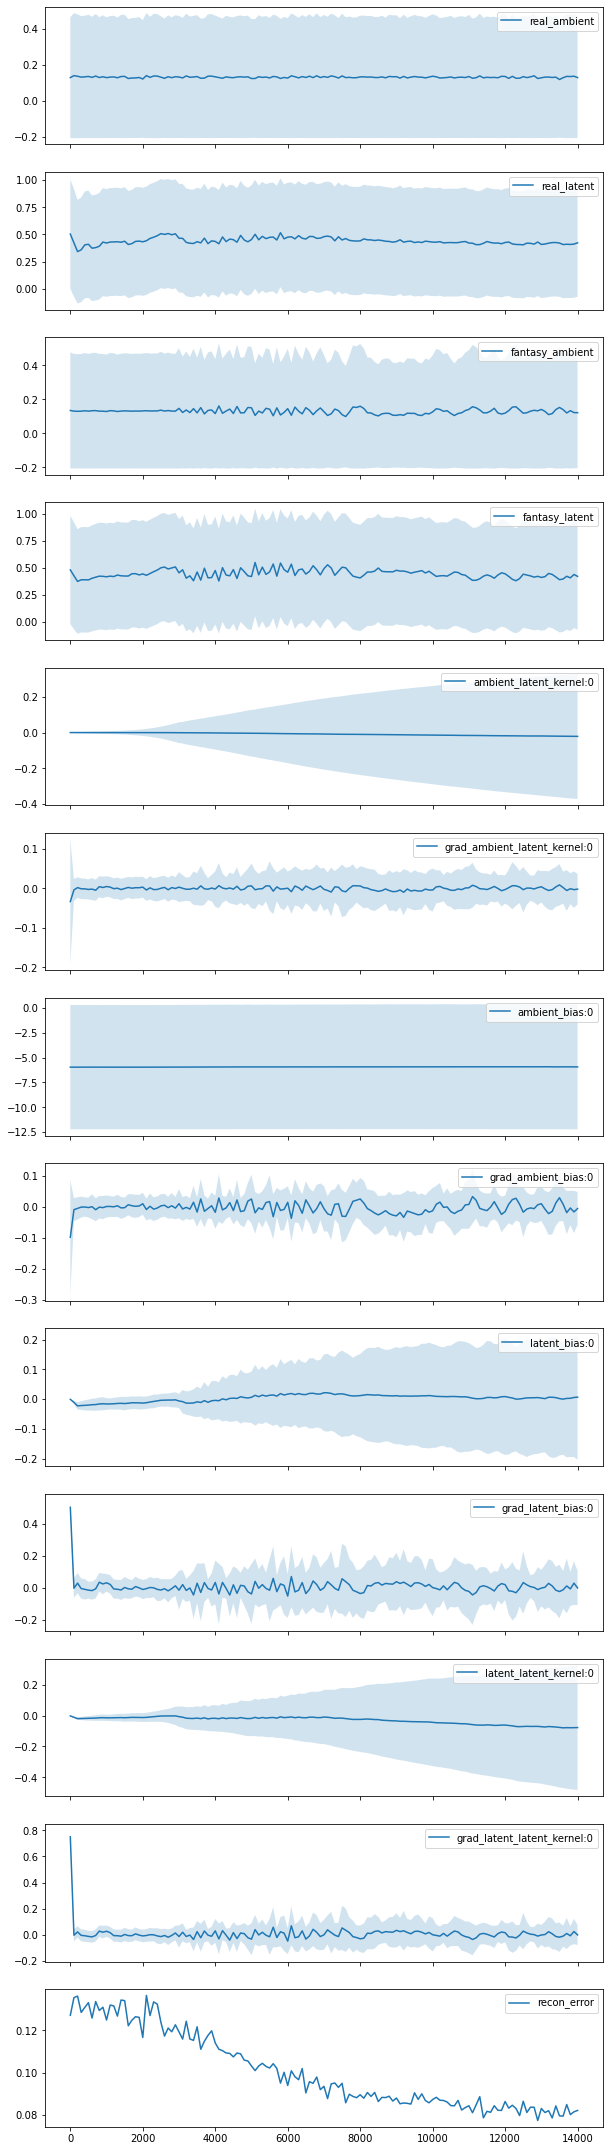

In [3]:
callbacks[0].plot_history()

# Visualize the Latent

In [4]:
from sklearn.manifold import TSNE
from maxent.boltzmann.base import relax_ambient

def get_relaxed_latent_projection(
        bm, ambient, max_step=100, tolerance=1e-1):
    relaxed_state, _ = relax_ambient(bm, ambient, max_step, tolerance)
    projection = TSNE().fit_transform(relaxed_state.latent)
    return projection

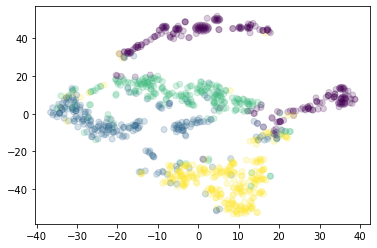

In [5]:
import numpy as np
import matplotlib.pyplot as plt

labels = {1, 2, 3, 4}
X_in_labels, y_in_labels = [], []
for xi, yi in zip(X, y):
    yi = np.argmax(yi)  # y is one-hot encoded.
    if yi in labels:
        X_in_labels.append(xi)
        y_in_labels.append(yi)
    if len(X_in_labels) == 1000:
      break

Z = get_relaxed_latent_projection(bm, np.array(X_in_labels))
plt.scatter(Z[:, 0], Z[:, 1], c=y_in_labels, alpha=0.2)
plt.show()

# Pruning

In [7]:
from maxent.boltzmann.base import quantize

qbm = quantize(bm, 1e-1, True)
get_reconstruction_error(qbm, X[:5000])

<tf.Tensor: shape=(), dtype=float32, numpy=0.08306015>

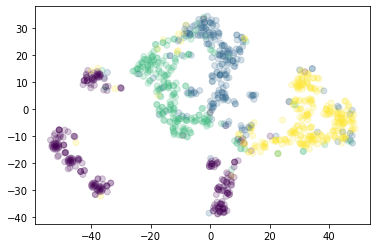

In [8]:
qZ = get_relaxed_latent_projection(qbm, np.array(X_in_labels))
plt.scatter(qZ[:, 0], qZ[:, 1], c=y_in_labels, alpha=0.2)
plt.show()

In [9]:
tf.reduce_mean(tf.where(tf.abs(bm.ambient_latent_kernel) > 0, 1., 0.)), \
tf.reduce_mean(tf.where(tf.abs(bm.latent_latent_kernel) > 0, 1., 0.))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.08074951>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.984375>)

In [10]:
tf.reduce_mean(tf.where(tf.abs(qbm.ambient_latent_kernel) > 0, 1., 0.)), \
tf.reduce_mean(tf.where(tf.abs(qbm.latent_latent_kernel) > 0, 1., 0.))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.07110596>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.74316406>)